# Running the simulations

In [9]:
r_max, hex_size = 75, 1.56
length = 2600
liquid_gap = 5
gas_gap = 5
drift_field = 100

In [9]:
Xenoscope = TPC(r_max, length, liquid_gap, gas_gap, drift_field)
mesh = Xenoscope.gate_mesh
lamp = XeLamp(1)

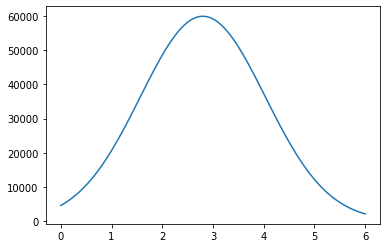

In [78]:
_t = np.linspace(0,6,100)
plt.plot(_t, lamp.pulse_lamp(_t))
plt.show()

182208


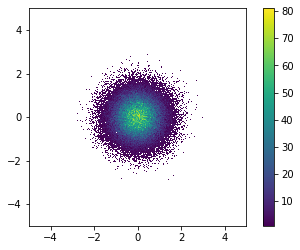

In [214]:
population = lamp.emitted_electrons_in_interval(0,6)
print(population)
x0,y0,z0 = lamp.init_positions(population)

plt.hist2d(x0,y0, bins = 200, cmin = 1)
plt.gca().set_aspect('equal')
plt.ylim(-5,5)
plt.xlim(-5,5)
plt.colorbar()
plt.show()

#### Drifting a slice of lamp pulse

In [32]:
lamp = XeLamp(delta_t_lamp = 1)
drifting = ElectronDrift(tpc = Xenoscope, 
                         xelamp = lamp,
                         drift_delta_t = 1)

In [28]:
x,y,z = drifting.drift_lamp_pulse_slice(0,6)

In [71]:
def plot_xy(fig,ax,x,y,stuff = {}):
    hh = ax.hist2d(x,y, bins = 200, cmin = 1)
    ax.set_aspect('equal')
    ax.set_title('%.2f us : %.2f us' %(stuff['lamp_start'],stuff['lamp_end']))
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    fig.colorbar(hh[3], ax = ax)
    return fig,ax

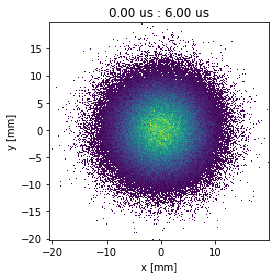

In [52]:
fig, ax = plt.subplots(1,1,figsize = (9,4))
ax = plot_xy(ax,x,y,{'lamp_start':0, 'lamp_end':6})
plt.show()

#### Drifting all the lamp pulse

In [64]:
lamp = XeLamp(delta_t_lamp = 1)
drifting = ElectronDrift(tpc = Xenoscope, 
                         xelamp = lamp,
                         drift_delta_t = 1)

In [65]:
pos_lamp_pulse = drifting.drift_full_pulse(lamp_end_time = 6)

100%|██████████| 7/7 [00:40<00:00,  5.84s/it]


In [66]:
pos_lamp_pulse['slice_0'].keys()

dict_keys(['start', 'end', 'delta_t_lamp', 'x', 'y', 'z'])

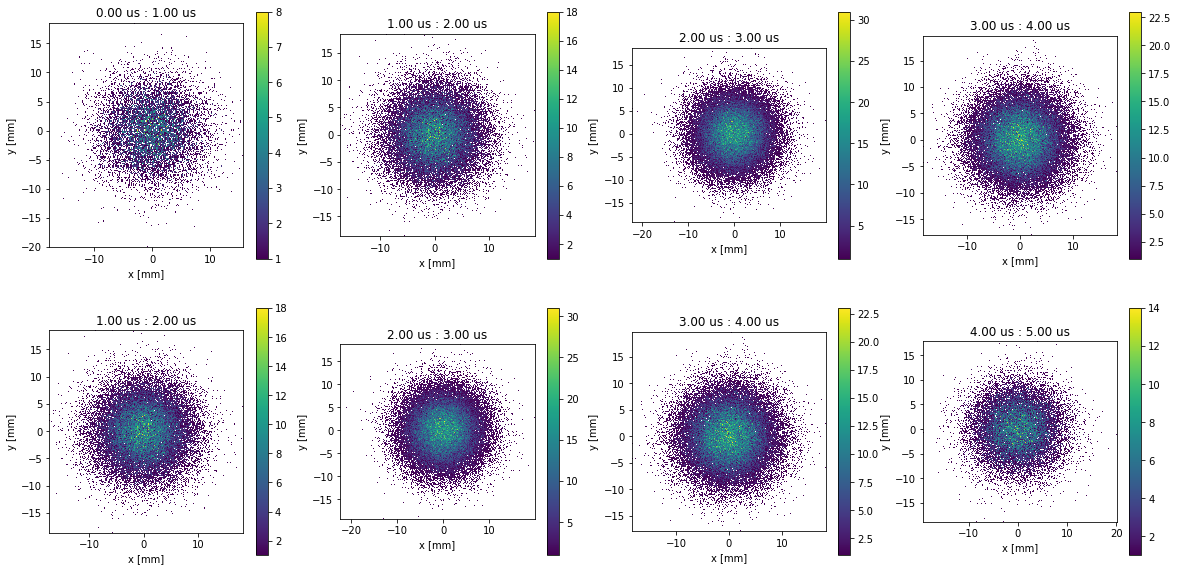

In [72]:
fig, axs = plt.subplots(2,4,figsize = (20,10))
rows,columns = axs.shape
ax_i = 0
for _row in range(rows):
    for _col in range(columns):
        
        if ax_i > len(pos_lamp_pulse):
            break
        lamp_start = pos_lamp_pulse['slice_%d'%ax_i]['start']
        lamp_end = pos_lamp_pulse['slice_%d'%ax_i]['end']
        x = pos_lamp_pulse['slice_%d'%ax_i]['x']
        y = pos_lamp_pulse['slice_%d'%ax_i]['y']
        axs[_row,_col] = plot_xy(fig,axs[_row,_col],x,y,{'lamp_start':lamp_start, 'lamp_end':lamp_end})
        ax_i +=1
plt.show()

#### Using the fully integrated lamp pulse

In [10]:
Xenoscope = TPC(r_max, length, liquid_gap, gas_gap, drift_field)
mesh = Xenoscope.gate_mesh
lamp = XeLamp(delta_t_lamp = 1)
drifting = ElectronDrift(tpc = Xenoscope, 
                         xelamp = lamp,
                         drift_delta_t = 1)
drifting.e_lifetime = 2000

In [39]:
# generating and drifting the electrons
x,y,z = drifting.drift_lamp_pulse_slice(0,6)

In [40]:
#Applying e-lifetime and extraction efficiency
x_corr_elifetime,y_corr_elifetime,z_corr_elifetime = drifting.apply_elifetime(x,y,z)
x_extracted,y_extracted, z_extracted = drifting.extract_electrons(x_corr_elifetime,y_corr_elifetime,z_corr_elifetime)

#Focusing on hax centers
e_pos = np.stack((x_extracted, y_extracted, z_extracted), axis = 1)

pos_focus = mesh.focus_on_grid(e_pos)

pos_counts = mesh.count_focused(pos_focus)

counts_pe_on_hex = drifting.convert_electron_to_photons(pos_counts)

Counting hits in hex centers: 100%|██████████| 3808/3808 [00:00<00:00, 5296.18it/s]


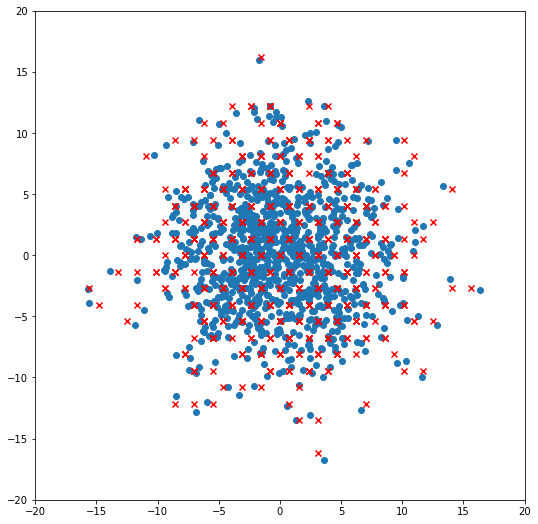

In [23]:
plt.figure(figsize = (9,9))
plt.scatter(e_pos[:1000,0], e_pos[:1000,1], label = 'unfocused')
plt.scatter(pos_focus[:1000,0], pos_focus[:1000,1], label = 'focused',
            marker = 'x', c = 'r')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.gca().set_aspect('equal')
plt.show()

Counting hits in hex centers: 100%|██████████| 3808/3808 [00:00<00:00, 4730.86it/s]


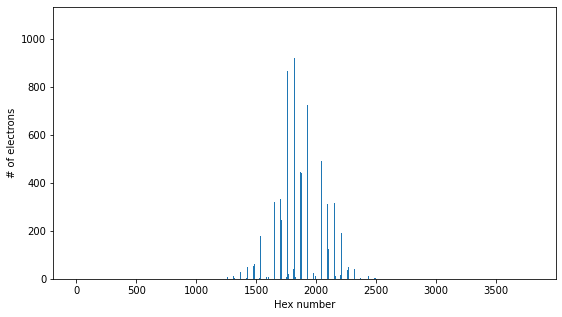

In [25]:
plt.figure(figsize=(9,5))
plt.bar(np.arange(0,mesh.n_hexes,1),pos_counts)
plt.xlabel('Hex number')
plt.ylabel('# of electrons')
plt.show()

#### Getting final pattern

In [110]:
r_max, hex_size = 75, 1.56
length = 2600
liquid_gap = 5
gas_gap = 5
drift_field = 100

In [129]:
pattern_path = '/dali/lgrandi/peres/xenoscope/diffusion/LCE_patterns/'
Xenoscope = TPC(r_max, length, liquid_gap, gas_gap, drift_field)
mesh = Xenoscope.gate_mesh
lamp = XeLamp(delta_t_lamp = 1)
drifting = ElectronDrift(tpc = Xenoscope, 
                         xelamp = lamp,
                         drift_delta_t = 1)
drifting.e_lifetime = 2000
top_array = TopArray(tpc = Xenoscope, 
                     mesh = mesh,
                     model_version = 0,
                     path_to_patterns = pattern_path)

In [22]:
pattern = top_array.load_pattern(1854)

/tmp/jobs/19738807/ipykernel_98/3736048605.py:150: RuntimeWarning: invalid value encountered in log10
  interpolated = ax.scatter(_xx, _yy, c=np.log10(_zz), marker = 's', s = 3, vmin = -6.2)


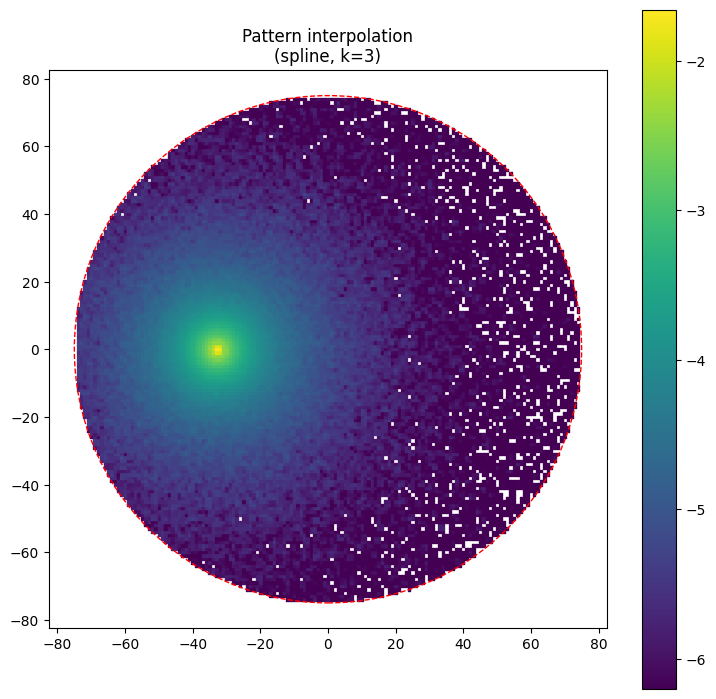

In [17]:
LCEPattern.plot_pattern(pattern,1854)

In [38]:
#top_array.load_all_patterns()

Loading LCE patterns.: 100%|██████████| 3808/3808 [01:28<00:00, 43.07it/s]


In [130]:
#patterns_save = top_array.patterns
top_array.patterns = patterns_save.copy()

In [31]:
#test resutls grid
#_zz = pattern.ev(top_array.grid_xx,top_array.grid_yy)

In [131]:
top_array.fill_grid_from_events(counts_pe_on_hex)

Summing all normalized patterns. 1+1+2+3+5+8+...: 100%|██████████| 3808/3808 [00:03<00:00, 1263.13it/s] 


In [96]:
def plot_results(fig, ax,top_array):
    xx = top_array.grid_xx
    yy = top_array.grid_yy
    zz = top_array.grid_zz
    rr = TPC.get_r(xx,yy)
    xx = xx[rr < Xenoscope.radius]
    yy = yy[rr < Xenoscope.radius]
    zz = zz[rr < Xenoscope.radius]
    
    
    ax.set_title('Summed results')
    sc = ax.scatter(xx, yy,
                    c=np.log10(zz),
               marker = 's', s = 10, vmin = 0,alpha = 0.8)

    ax.add_patch(Circle((0,0),75, color = 'r',fill = False, linewidth = 1, ls ='--'))
    ax.set_aspect('equal')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    fig.colorbar(sc, ax = ax, label = 'pe$\cdot$mm$^{-2}$')
    
    ax = top_array.plot_toparray(ax)
    return fig,ax

In [132]:
top_array.load_top_array()

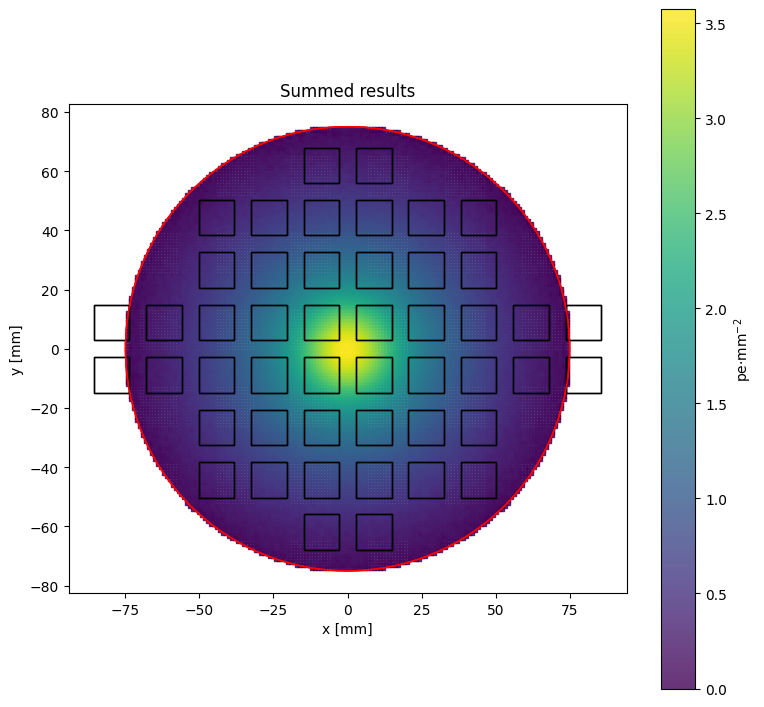

In [154]:
fig,ax = plt.subplots(1,1,figsize = (9,9), dpi = 100)
fig, ax = plot_results(fig, ax, top_array)
ax = top_array.plot_toparray(ax)

plt.savefig('figures/results_with_array.png')
plt.show()

TypeError: %d format: a number is required, not str

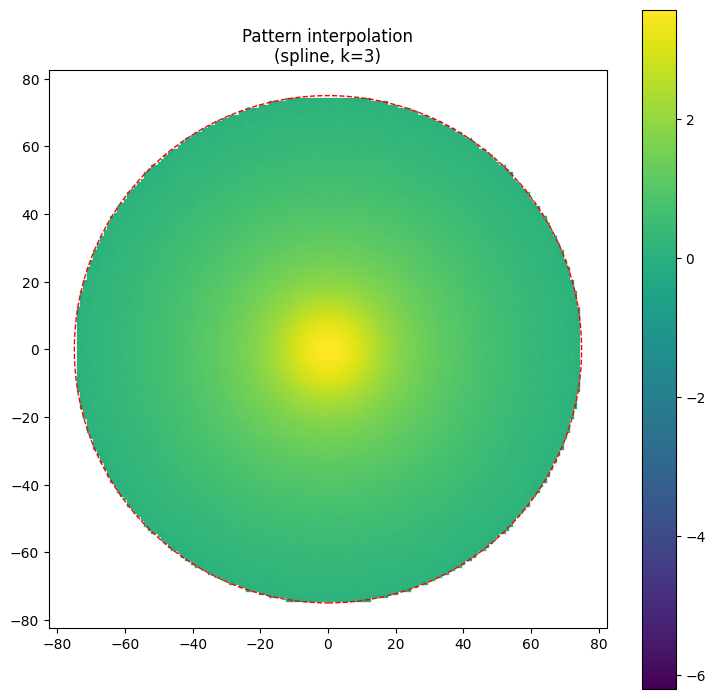

In [79]:
LCEPattern.plot_pattern(top_array.results_interp,'results')

#### Getting the integration in the quads and plots

In [133]:
n_pe_quads = top_array.n_pe_in_quads()

In [116]:
import matplotlib as mpl

##### Quads

In [319]:
top_array = TopArray(tpc = Xenoscope, 
                     mesh = mesh,
                     model = 'quads',
                     path_to_patterns = pattern_path)

top_array.patterns = patterns_save.copy()
top_array.fill_grid_from_events(counts_pe_on_hex)
top_array.load_top_array()
n_pe_quads = top_array.n_pe_in_sensors()


Summing all normalized patterns. 1+1+2+3+5+8+...: 100%|██████████| 3808/3808 [00:02<00:00, 1301.24it/s] 


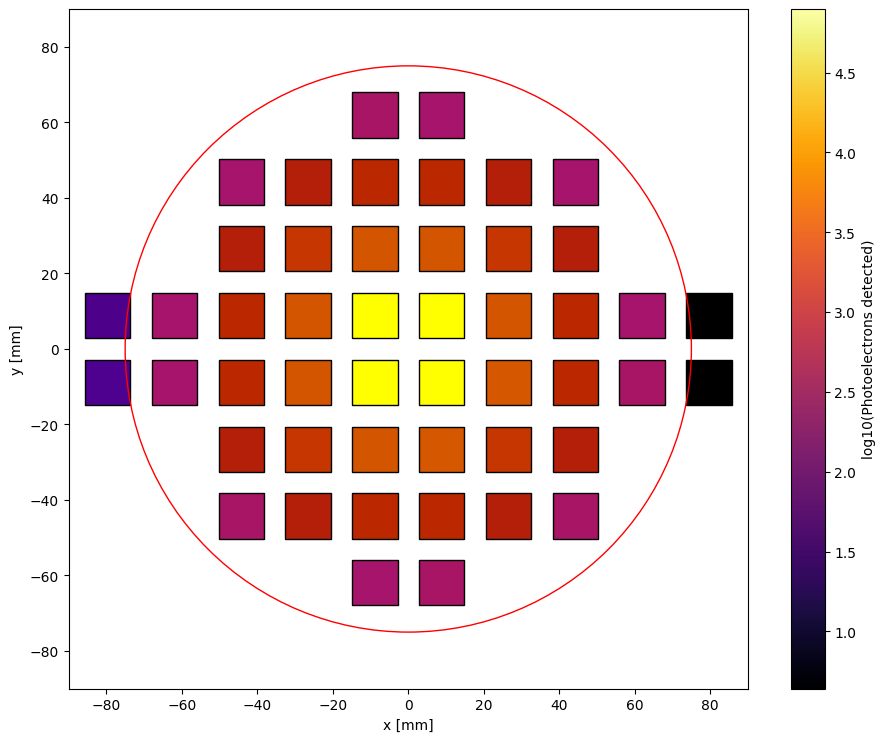

In [320]:
fig,ax = plt.subplots(1,1,figsize = (11,9), dpi = 100)
#fig, ax = plot_results(fig, ax, top_array, res)
ax = top_array.plot_toparray(ax,pe_in_sensors=True)


cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(vmin=np.log10(np.min(n_pe_quads)), 
                            vmax=np.log10(np.max(n_pe_quads)))

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='log10(Photoelectrons detected)')
plt.savefig('figures/results_in_quads.png')
plt.show()

##### 6x6

In [321]:
top_array = TopArray(tpc = Xenoscope, 
                     mesh = mesh,
                     model = 'sixbysixs',
                     path_to_patterns = pattern_path)

top_array.patterns = patterns_save.copy()
top_array.fill_grid_from_events(counts_pe_on_hex)
top_array.load_top_array()
n_pe_quads = top_array.n_pe_in_sensors()


Summing all normalized patterns. 1+1+2+3+5+8+...: 100%|██████████| 3808/3808 [00:02<00:00, 1271.20it/s] 


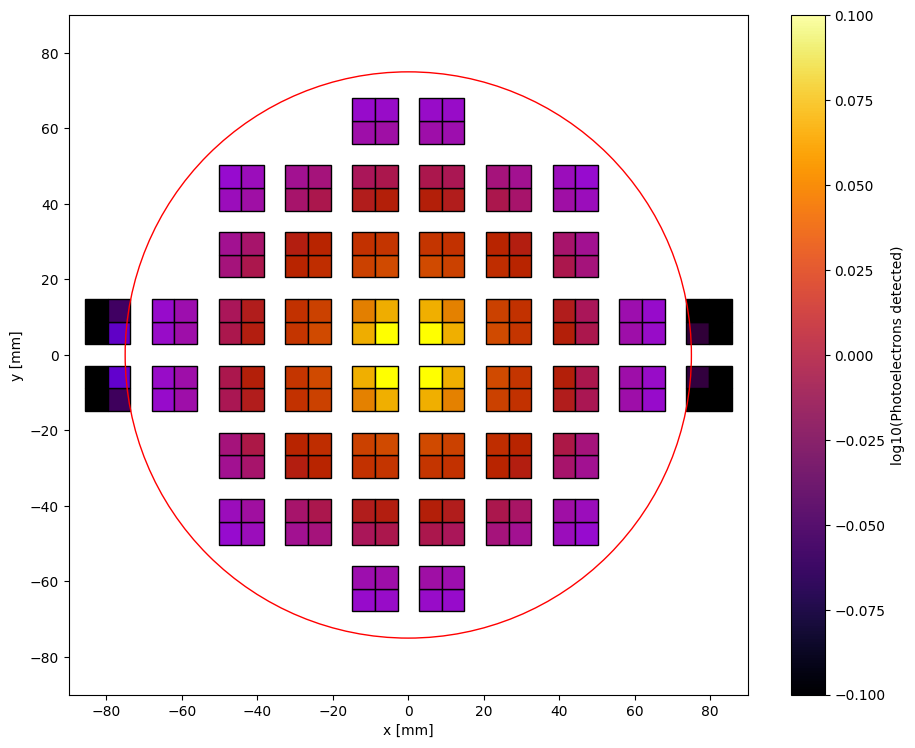

In [322]:
fig,ax = plt.subplots(1,1,figsize = (11,9), dpi = 100)
#fig, ax = plot_results(fig, ax, top_array, res)
ax = top_array.plot_toparray(ax,pe_in_sensors=True)

cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(vmin=np.log10(np.min(n_pe_quads)), 
                            vmax=np.log10(np.max(n_pe_quads)))

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='log10(Photoelectrons detected)')
plt.savefig('figures/results_in_6x6.png')
plt.show()

##### Hybrid1

In [327]:
top_array = TopArray(tpc = Xenoscope, 
                     mesh = mesh,
                     model = 'hybrid',
                     path_to_patterns = pattern_path)

top_array.patterns = patterns_save.copy()
top_array.fill_grid_from_events(counts_pe_on_hex)
top_array.load_top_array()
n_pe_quads = top_array.n_pe_in_sensors()


Summing all normalized patterns. 1+1+2+3+5+8+...: 100%|██████████| 3808/3808 [00:02<00:00, 1277.61it/s] 


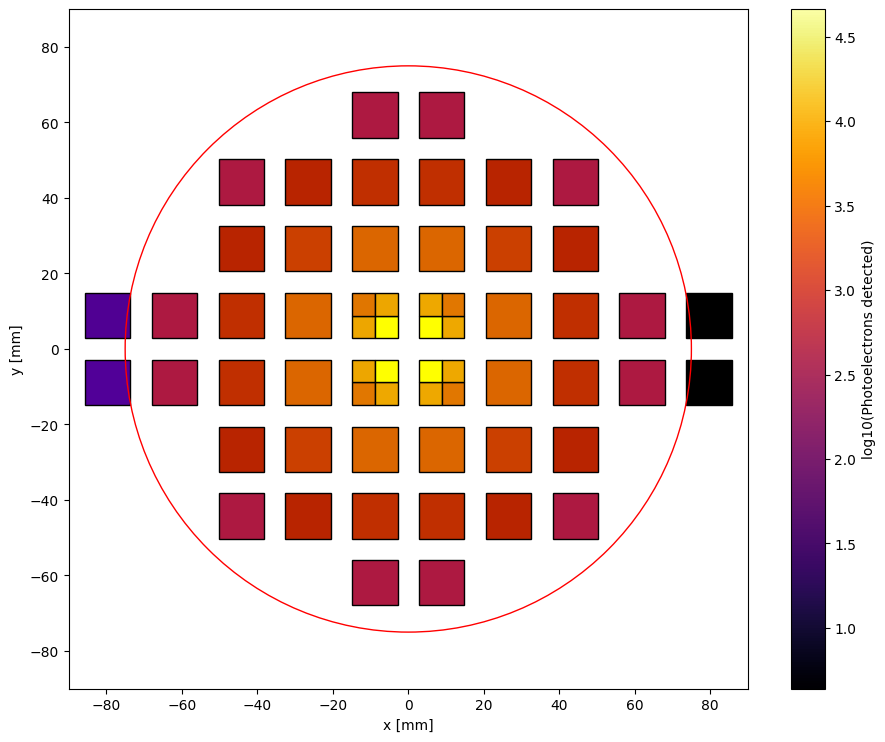

In [328]:
fig,ax = plt.subplots(1,1,figsize = (11,9), dpi = 100)
#fig, ax = plot_results(fig, ax, top_array, res)
ax = top_array.plot_toparray(ax,pe_in_sensors=True)

cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(vmin=np.log10(np.min(n_pe_quads)), 
                            vmax=np.log10(np.max(n_pe_quads)))

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='log10(Photoelectrons detected)')
plt.savefig('figures/results_in_hybrid1.png')
plt.show()

##### Hybrid2

In [345]:
top_array = TopArray(tpc = Xenoscope, 
                     mesh = mesh,
                     model = 'hybrid2',
                     path_to_patterns = pattern_path)

top_array.patterns = patterns_save.copy()
top_array.fill_grid_from_events(counts_pe_on_hex)
top_array.load_top_array()
n_pe_quads = top_array.n_pe_in_sensors()


Summing all normalized patterns. 1+1+2+3+5+8+...: 100%|██████████| 3808/3808 [00:02<00:00, 1309.20it/s] 


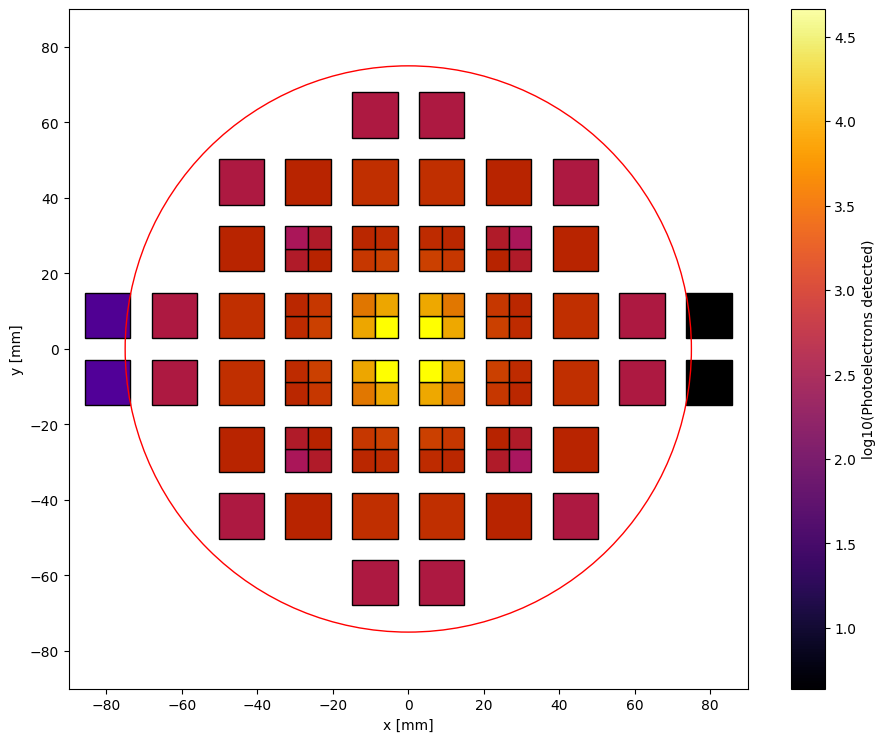

In [346]:
fig,ax = plt.subplots(1,1,figsize = (11,9), dpi = 100)
#fig, ax = plot_results(fig, ax, top_array, res)
ax = top_array.plot_toparray(ax,pe_in_sensors=True)

cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(vmin=np.log10(np.min(n_pe_quads)), 
                            vmax=np.log10(np.max(n_pe_quads)))

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='vertical', label='log10(Photoelectrons detected)')
plt.savefig('figures/results_in_hybrid2.png')
plt.show()

## Random event generator

In [343]:
def test_xy(x,y):
    print('Start!')
    boop = LCEPattern(Xenoscope)
    boop.n_traces = int(1e5)
    hits = boop.get_hits_on_circ_array(x,y,5)
    print('Focusing on hexes')
    hits2 = mesh.focus_on_grid(hits)
    hits3 = mesh.count_focused(hits2)
    hits4 = drifting.convert_electron_to_photons(hits3)
    
    top_array = TopArray(tpc = Xenoscope, 
                     mesh = mesh,
                     model = 'hybrid2',
                     path_to_patterns = pattern_path)

    top_array.patterns = patterns_save.copy()
    top_array.fill_grid_from_events(hits4)
    top_array.load_top_array()
    n_pe_quads = top_array.n_pe_in_sensors()

    fig,ax = plt.subplots(1,1,figsize = (11,9), dpi = 100)
    #fig, ax = plot_results(fig, ax, top_array, res)
    ax = top_array.plot_toparray(ax,pe_in_sensors=True)

    cmap = mpl.cm.inferno
    norm = mpl.colors.Normalize(vmin=np.log10(np.min(n_pe_quads)), 
                                vmax=np.log10(np.max(n_pe_quads)))

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=ax, orientation='vertical', label='log10(Photoelectrons detected)')
    #plt.savefig('figures/results_test_2.png')
    plt.show()

Start!
Focusing on hexes


Summing all normalized patterns. 1+1+2+3+5+8+...: 100%|██████████| 3808/3808 [00:12<00:00, 314.12it/s]


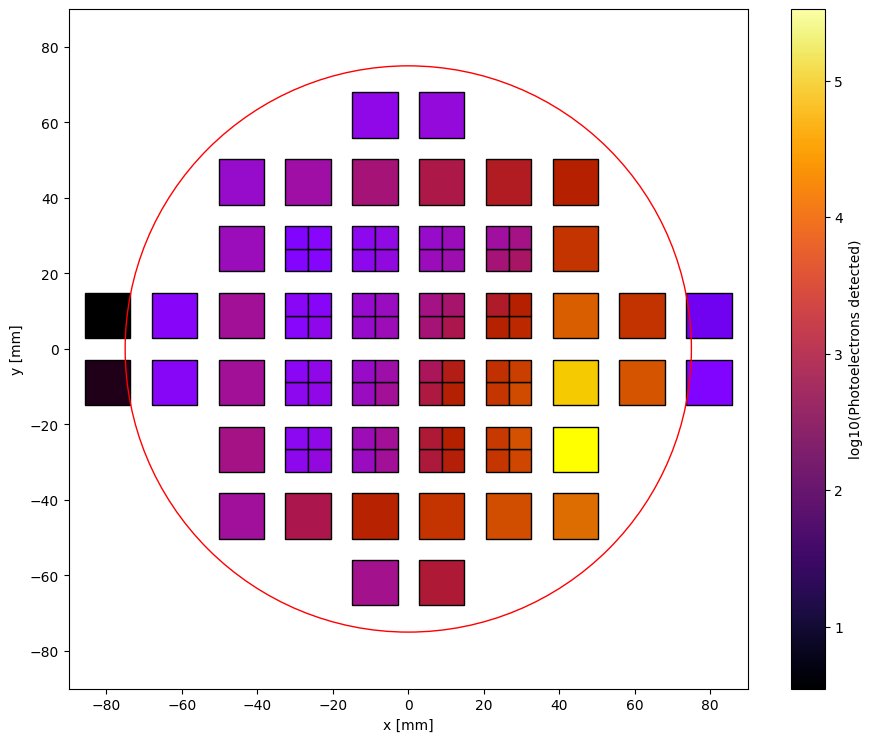

In [344]:
test_xy(50,-20)